# LC3 DATA ANALYSIS

### Load libraries and data

In [1]:
# Libraries for general data management
import pandas as pd
import numpy  as np

In [2]:
# Libraries for creating and validating models
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_val_score

In [3]:
# Libraries for data visualization
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches

In [4]:
# Input file path (can be also an excel)
DATA_MERGED_PATH = './data/data_merged.ods'
DATA_FULL_PATH   = './data/data_full.ods'

In [5]:
# Read full data and remove empty lines
data_full = pd.read_excel(DATA_FULL_PATH,sheet_name='Clays_CS')
data_full.dropna(how="all", inplace=True)

In [6]:
# Read clay properties
data_clay   = pd.read_excel(DATA_FULL_PATH,sheet_name='Clays_properties')

In [7]:
# Merge to have the whole dataset
data_full_clay = pd.merge(data_full, data_clay, left_on='Clay', right_on='Clay', how='left')

In [8]:
# We rename some columns for having an easier reference
data_full_clay.rename(columns = {'Calcined kaolinite content (%)':'Kaolinite_content'}, inplace = True)
data_full_clay.rename(columns = {'Dv,50 (µm)':'Dv50'                                 }, inplace = True)
data_full_clay.rename(columns = {'BET Specific surface (m2/g)':'BET_specific_surface'}, inplace = True)

data_full_clay.rename(columns = {'STD'  : 'STD_1D'}, inplace = True)
data_full_clay.rename(columns = {'STD.1': 'STD_3D'}, inplace = True)
data_full_clay.rename(columns = {'STD.2': 'STD_7D'}, inplace = True)
data_full_clay.rename(columns = {'STD.3':'STD_28D'}, inplace = True)
data_full_clay.rename(columns = {'STD.4':'STD_90D'}, inplace = True)

# Sorting allows us to plot functions more easily
data_full_clay = data_full_clay.sort_values('Kaolinite_content')

# Get useful dataframe information
#data               # Get data
#data.describe()    # Get data general information
#data.columns       # Get data features names
#data.corr()        # Get correlation matrix

### Visualize data

In [9]:
# Take kaolinite content
x = data_full_clay['Kaolinite_content'].values # (Pandas dataframe).values = numpy array

# Take compression strengths
y1  = data_full_clay[ "day_1"].values
y3  = data_full_clay[ "day_3"].values
y7  = data_full_clay[ "day_7"].values
y28 = data_full_clay["day_28"].values
y90 = data_full_clay["day_90"].values

# Measures at 90 days have missing values (4 in total)
x1 =   x[np.logical_not(np.isnan(y1))]
y1 = y1[np.logical_not(np.isnan(y1))]
x3 =   x[np.logical_not(np.isnan(y3))]
y3 = y3[np.logical_not(np.isnan(y3))]
x7 =   x[np.logical_not(np.isnan(y7))]
y7 = y7[np.logical_not(np.isnan(y7))]
x28 =   x[np.logical_not(np.isnan(y28))]
y28 = y28[np.logical_not(np.isnan(y28))]
x90 =   x[np.logical_not(np.isnan(y90))]
y90 = y90[np.logical_not(np.isnan(y90))]

# Take standard deviations
#z1  = data[ "STD_1D"].values
#z3  = data[ "STD_3D"].values
#z7  = data[ "STD_7D"].values
#z28 = data["STD_28D"].values
#z90 = data["STD_90D"].values


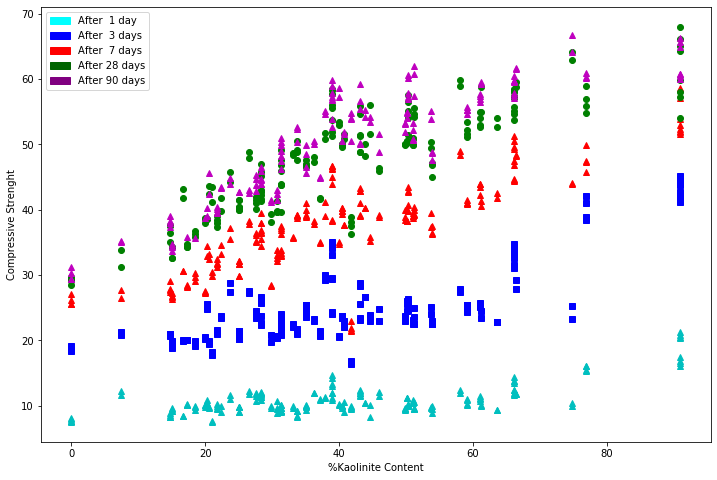

In [10]:
# Show points using matplotlib.pyplot library
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(x1,y1,'c^',x3,y3,'bs',x7,y7,'r^',x28,y28,'go', x90,y90,'m^' )
plt.xlabel('%Kaolinite Content')
plt.ylabel('Compressive Strenght')

d1_patch  = mpatches.Patch(color='cyan',      label='After  1 day')
d3_patch  = mpatches.Patch(color='blue',      label='After  3 days')
d7_patch  = mpatches.Patch(color='red',       label='After  7 days')
d28_patch = mpatches.Patch(color='darkgreen', label='After 28 days')
d90_patch = mpatches.Patch(color='purple',    label='After 90 days')
plt.legend(handles=[d1_patch,d3_patch,d7_patch,d28_patch,d90_patch])

plt.show()

# COMPRESSION STRENGTH (CS)

### Linear regression models

We have seen that the kaolinite content is the most predictive feature that we have. We are going to start creating simple linear regression models and then, following the appreciations obtained by visualizing the data, we are going to create non-linear models based on the kaolinite content for better fitting the data distribution as well as models with more features for avoiding data sparsification.

Two metrics are going to be extremely important here:
* **R square:** Is giving us a measurement of how good is our model (the closer to 1.0 the better). 
* **Validation score:** Is going to let us control overfitting. Improving R² means nothing if validation is worse. We'll use mean squared error with Leave One Out cross validation to estimate it.

In [11]:
# TODO: Remove outlier in y1 data?
# TODO: Idea for the report, removing pesimist outliers is not a good idea in our project!
# TODO: Add OPC compression strength values for reference

#### Linear models based on the kaolinite content

In [12]:
# Create, estimate, validate and show the model
def leave_one_out_validation(X, y, model=LinearRegression()):
    # Train the model
    model.fit(X, y) 
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(X, np.dot(X,model.coef_) + model.intercept_,'r-')
    ax.scatter(X, y, edgecolors=(0, 0, 0))
    ax.set_xlabel('% Kaolinite content')
    ax.set_ylabel('Compressive strength')
    plt.show()
    
    # Get the list of predictions obtained while validating
    predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    
    # Model and metrics
    print('f(x) = {0} + {1}*x'.format(model.intercept_, model.coef_[0]))
    print()
    print("MSE: {}".format(mean_squared_error(y, predicted)))
    print("R^2: {}".format(model.score(X,y)))

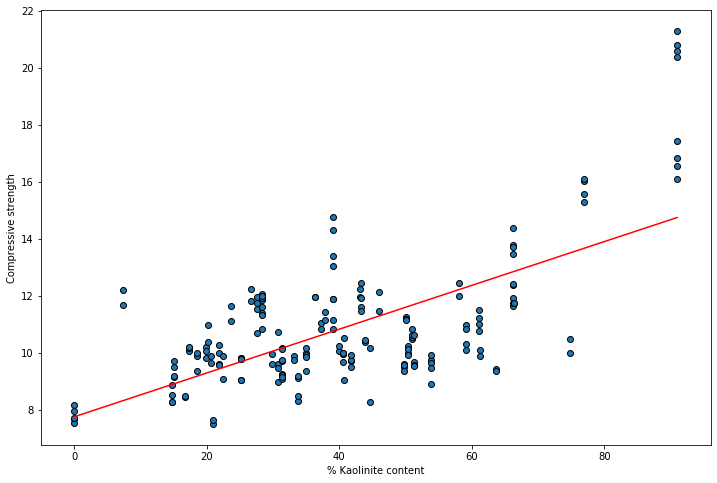

f(x) = 7.757071248182706 + 0.07675459691387534*x

MSE: 2.998686102097349
R^2: 0.45106283702868666


In [14]:
leave_one_out_validation(x1.reshape(-1,1), y1)

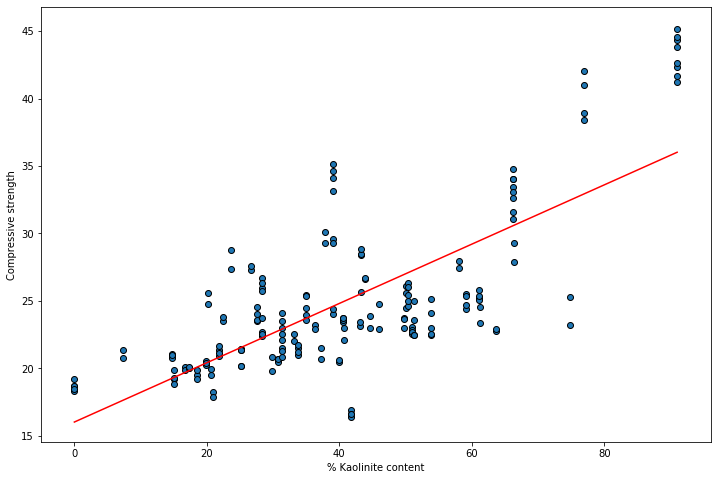

f(x) = 16.0129347537635 + 0.21986524992490422*x

MSE: 15.697474578920843
R^2: 0.5610131651986436


In [15]:
leave_one_out_validation(x3.reshape(-1,1), y3)

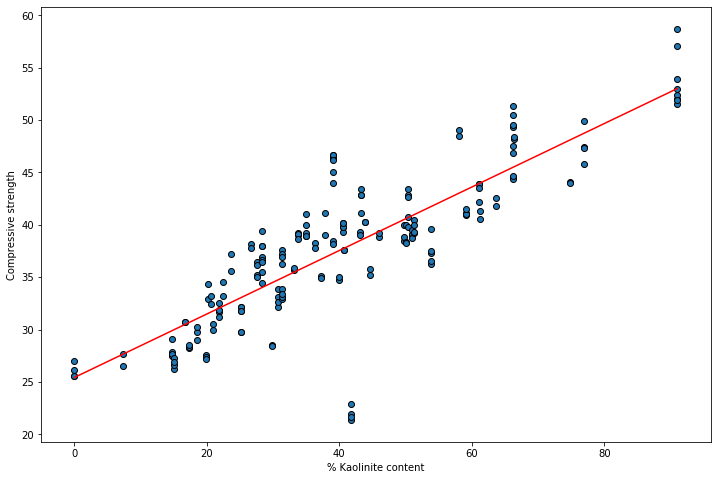

f(x) = 25.424926641182765 + 0.3029757706618903*x

MSE: 14.970514906218744
R^2: 0.7122933575429145


In [16]:
leave_one_out_validation(x7.reshape(-1,1), y7)

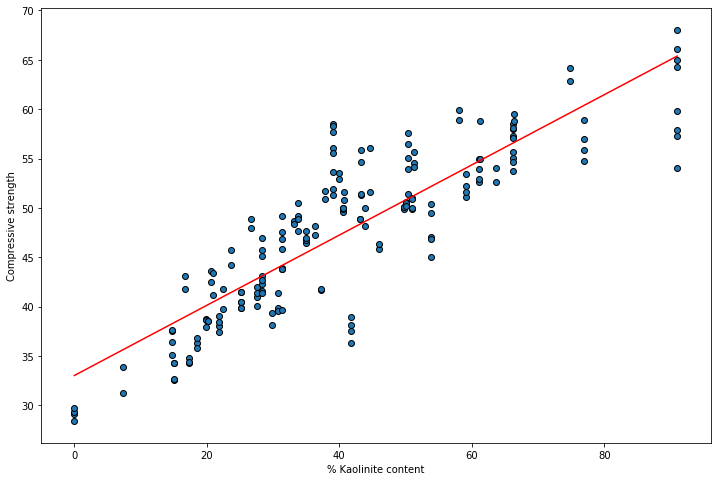

f(x) = 33.02538994622512 + 0.35549572601638785*x

MSE: 17.222221654814252
R^2: 0.750654935415253


In [17]:
leave_one_out_validation(x28.reshape(-1,1), y28)

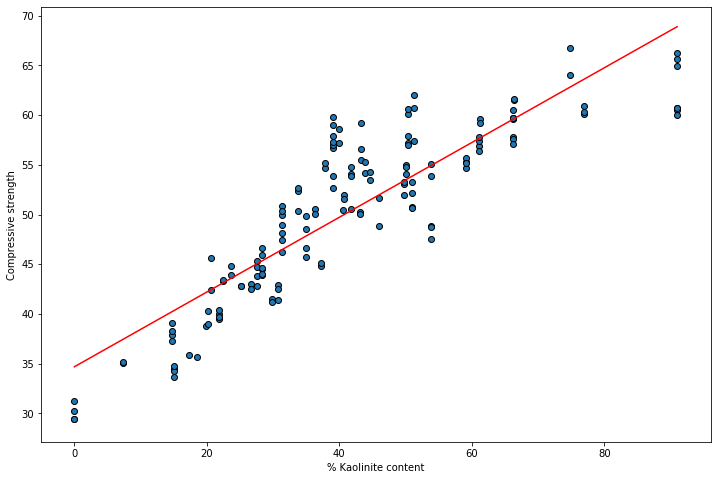

f(x) = 34.68065302145966 + 0.3759961910670364*x

MSE: 16.490038819375435
R^2: 0.7812631869011306


In [18]:
leave_one_out_validation(x90.reshape(-1,1), y90)

**First sight analysis:**

* There is few more we can improve at the 7th day using only the kaolinite content, data distribution is quite a straight line.
* For 1st and 3rd day the problem is more the sparsification of the points than the lack of expresivity of the model.
* For 28th and 90th day until 40% of kaolinite content the compression strength increases linearly and then estabilizes. Makes sense a non-linear model.
* It doesn't make sense in any model a degree 3 regression model, compression strength increases with kaolinite content.

#### Non-linear models based on the kaolinite content

In [19]:
# x_2 = Kaolinite content, (Kaolinite content)^2
x1_2   = np.array([x1, x1**2]).T
x3_2   = np.array([x3, x3**2]).T
x7_2   = np.array([x7, x7**2]).T
x28_2   = np.array([x28, x28**2]).T
x90_2 = np.array([x90,x90*x90]).T 

In [20]:
# Same function than before but adapted for degree two case
def leave_one_out_validation(X, y, model=LinearRegression()):
    # Train and show the model
    model.fit(X, y) 
    
    # This could be generalized but degree n >= 3 leads to overfitting!
    print('f(x) = {0} + {1}*x + {2}*x^2'.format(model.intercept_, model.coef_[0], model.coef_[1]))
        
    # Get the list of predictions obtained while validating
    predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(X[:,0], np.dot(X,model.coef_) + model.intercept_,'r-')
    ax.scatter(X[:,0], y, edgecolors=(0, 0, 0))
    ax.set_xlabel('% Kaolinite content')
    ax.set_ylabel('Compressive strength')
    plt.show()
    
    # Metrics for the model
    print("MSE: {}".format(mean_squared_error(y, predicted)))
    print("R^2: {}".format(model.score(X,y)))

f(x) = 10.310550266313658 + -0.06317775324896227*x + 0.0015247208198673223*x^2


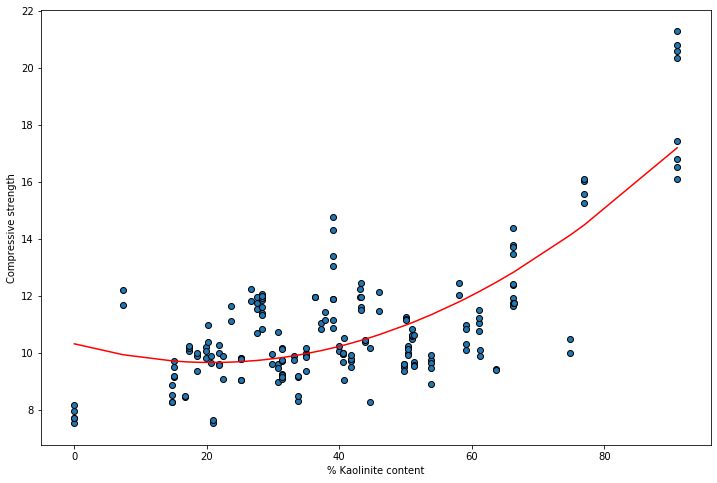

MSE: 2.3350676443848237
R^2: 0.5802361848393611


In [21]:
leave_one_out_validation(x1_2, y1)

f(x) = 21.675008175415584 + -0.09061197353494653*x + 0.0033808369398379058*x^2


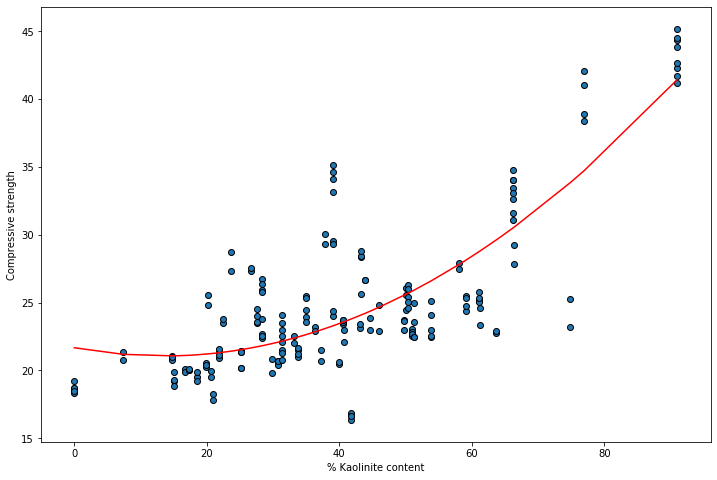

MSE: 12.233369051011191
R^2: 0.65793401200628


In [22]:
leave_one_out_validation(x3_2, y3)

f(x) = 25.176660948985223 + 0.31635448580481307*x + -0.00014424624640012586*x^2


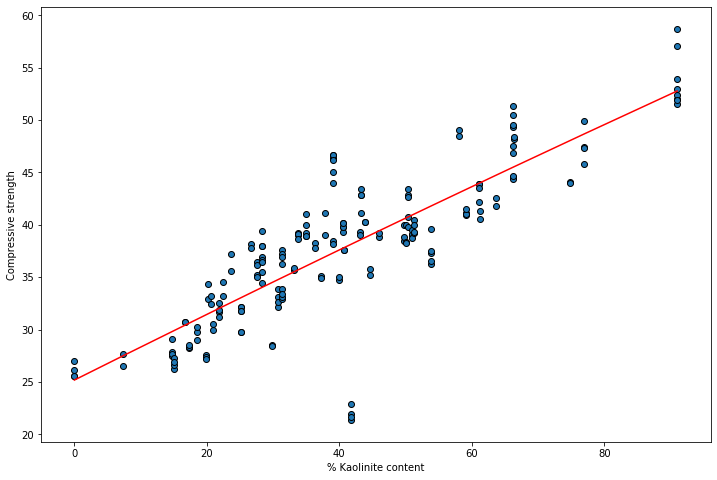

MSE: 15.078247077231065
R^2: 0.7124066034604744


In [23]:
leave_one_out_validation(x7_2, y7)

f(x) = 28.05932027789003 + 0.6235875190659592*x + -0.0028894158476503473*x^2


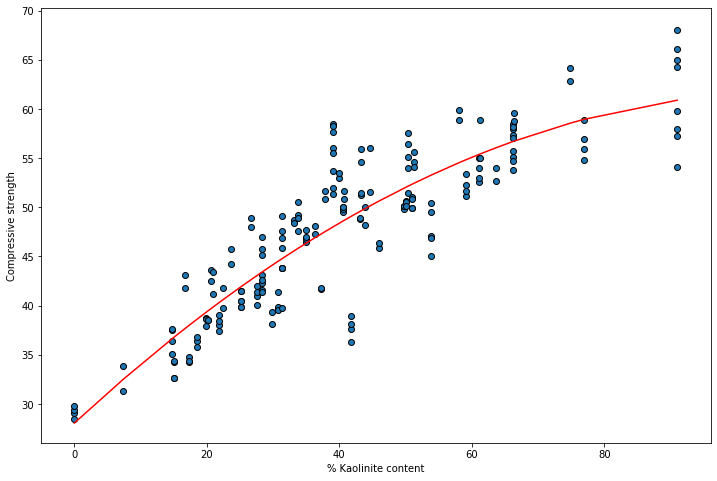

MSE: 14.966599071317171
R^2: 0.7853324275680789


In [24]:
leave_one_out_validation(x28_2, y28)

f(x) = 27.629447422887907 + 0.7559720854403904*x + -0.0041043446678189375*x^2


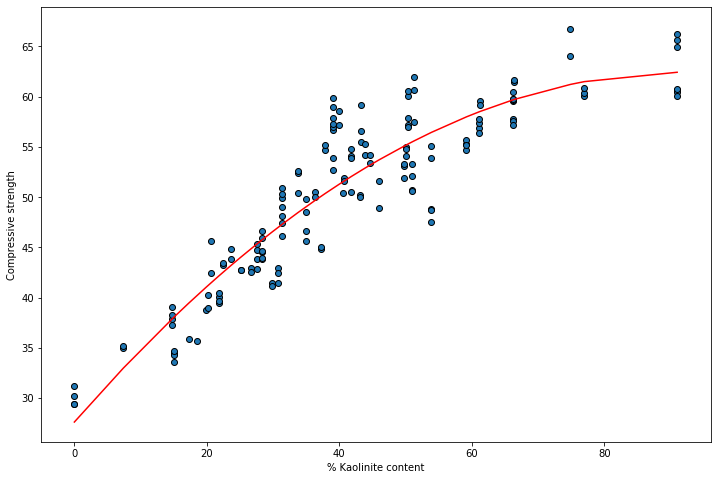

MSE: 11.177755734084075
R^2: 0.8520455681681612


In [25]:
leave_one_out_validation(x90_2, y90)

**First sight analysis:**

* Expected results, better models obtained for 28th and 90th day compression strength obtained.
* We might be experiencing overfitting with this model for 1st and 3rd day measurements because we're not increasing the compressive strength with the increase of calonita for small contents.

### Feature selection

In [26]:
#### TODO

In [27]:
# Which features are realiable? Those with more than RELIABLE_THRESHOLD measurements
RELIABLE_THRESHOLD = 45

features = data_full_clay.columns[14:]
reliable_features = [f for f in features if data_full_clay[f].describe()[0] >= RELIABLE_THRESHOLD]

In [28]:
# Show the reliable features, with enough points to rely
#reliable_features

In [29]:
# Function to return the R2 and validation score for a model (linear regression by default)
def model_validation(X, y, model=LinearRegression()):
    # Train the model
    model.fit(X, y) 
    # Get the list of predictions obtained while validating
    predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    
    # Return the metrics
    return model.score(X,y), mean_squared_error(y, predicted)

In [30]:
# TODO: We are computing metrics for every feature, why not building a matrix with all te information?

# Function to perform feature selection from those given as parameter. It choses those
# features that better complements kaolinite content for achieving the best R2 and MSE.
def feature_selection(features, days=[1,3,7,28,90]):
    # For every day we want to do feature selection
    for i in days:    
        day = 'day_'+str(i)
        bestR2  = -1 
        bestMse = float('inf')
        
        # Go for every feature given and check wich results we get with it
        for feature in features:
            # IMPORTANT! Metrics can cheat us if we drop NaNs!!
            # IMPORTANT! That's what we have to rely the features we are testing!!
            df = data_full_clay[['Kaolinite_content', feature, day]].dropna()
            df['Kaolinite_content_square'] = (df['Kaolinite_content'].values)**2
            
            # Kaolinite content is always in our features in degree one and two
            X = df[['Kaolinite_content', 'Kaolinite_content_square', feature]].values
            y = df[day].values
        
            # Get the metrics
            r2, mse = model_validation(X,y)
            
            # Keep the bests
            if r2 > bestR2:
                bestR2         = r2
                bestR2_mse     = mse
                bestR2_feature = feature
            
            if mse < bestMse:
                bestMse        = mse
                bestMse_r2     = r2
                bestMse_feature= feature
        
            #print('Kaolinite content +  Kaolinite content square + '+feature)
            #print('R2:  '+str(r2))
            #print('MSE: '+str(mse))
        
        # Print report for this day 
        print('=============================================================================')
        print('Best features for compression strength at day '+str(i))
        print('=============================================================================')
        print()
        print('Best R2  achieved for degree two kaolinite content and '+bestR2_feature)
        print('R2:  '+str(bestR2))
        print('MSE: '+str(bestR2_mse))
        print()
        print('Best MSE achieved for degree two kaolinite content and '+bestMse_feature)
        print('R2:  '+str(bestMse_r2))
        print('MSE: '+str(bestMse))
        print()    

In [31]:
#feature_selection(reliable_features)
#feature_selection(features)

#### Linear regression models based on the kaolinite content and other features

Following the results obtained in the feature selection part, here we are creating and analyzing the models done with the kaolinite conent (in degree one and two) as well as other feature.

In [32]:
### TODO

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [34]:
# Funcion for returning the data ready for creating models with kaolinite and a given feature
def get_model_data(feature, day, drop_nan=True, replace_nan=False):
    # Get kaolinite content in degree one and two and the parameter feature
    df_aux = data[['Kaolinite_content', feature, day]]
    df_aux.insert(1, 'Kaolinite_content_square', data['Kaolinite_content']**2, True)
    # Copy for data integrity if we replace NaN
    df_aux = df_aux.copy()
    
    if drop_nan:
        df_aux = df_aux.dropna()
    elif replace_nan:
        df_aux.fillna(value=df_aux[feature].mean(), inplace=True)
    
    df_aux.rename(columns = {day : 'day_'+day[0]}, inplace = True)
    
    return df_aux

In [ ]:
# Day 1 
mod = smf.ols(formula='day_1 ~ Kaolinite_content + Kaolinite_content_square + Dv50', data=get_model_data('Dv50','1D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 1 
mod = smf.ols(formula='day_1 ~ Kaolinite_content + Kaolinite_content_square + CaO', data=get_model_data('CaO','1D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 3
mod = smf.ols(formula='day_3 ~ Kaolinite_content + Kaolinite_content_square + Dv50', data=get_model_data('Dv50','3D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 3
mod = smf.ols(formula='day_3 ~ Kaolinite_content + Kaolinite_content_square + CaO', data=get_model_data('CaO','3D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 7
mod = smf.ols(formula='day_7 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data('BET_specific_surface','7D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 28
mod = smf.ols(formula='day_2 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data('BET_specific_surface','28D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 28
mod = smf.ols(formula='day_2 ~ Kaolinite_content + Kaolinite_content_square + TiO2', data=get_model_data('TiO2','28D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 90
mod = smf.ols(formula='day_9 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data('BET_specific_surface','90D'))
np.random.seed(2)
res = mod.fit()
res.summary()

In [ ]:
# Day 90
mod = smf.ols(formula='day_9 ~ Kaolinite_content + Kaolinite_content_square + TiO2', data=get_model_data('TiO2','90D'))
np.random.seed(2)
res = mod.fit()
res.summary()

### Confidence analysis for the models

We know our model (function depending on the features provided) as well as some metrics to have an idea of how well our model fits our data (R2) and how is it behaving in practice with new data (MSE). The objetive of this section is to provide a more mathematical analysis of the confidence we can expect from our models.

#### Toy example for putting things into practice

We are going to start with the Kaolinite content based model for compression strength at day 90 to exemplify the tools and techniques we can use to estimate confidence intervals in our model.

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [36]:
data_90=data_full_clay[['day_90','Kaolinite_content']].dropna().copy()
data_90.insert(2, 'Kaolinite_content_square', data_90['Kaolinite_content']**2, True)

In [37]:
# Day 90
mod = smf.ols(formula='day_90 ~ Kaolinite_content_square + Kaolinite_content', data=data_90)
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_90   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     426.2
Date:                Thu, 10 Dec 2020   Prob (F-statistic):           3.89e-62
Time:                        11:27:42   Log-Likelihood:                -393.98
No. Observations:                 151   AIC:                             794.0
Df Residuals:                     148   BIC:                             803.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   27.6294      1.044     26.465      0.000      25.566      29.693
Kaolinite_content_square    -0.0041      0.000     -8.415      0.000      -0.005      -0.003
Kaolinite_content            0.7560      0.047     16.044      0.000       0.663       0.849
==============================================================================
Omnibus:                        1.561   Durbin-Watson:                   0.629
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                1.359
Skew:                           0.232   Prob(JB):                        0.507
Kurtosis:                       3.027   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

f(x) = 27.629447422887896 + 0.7559720854403887*x + -0.0041043446678187285*x^2


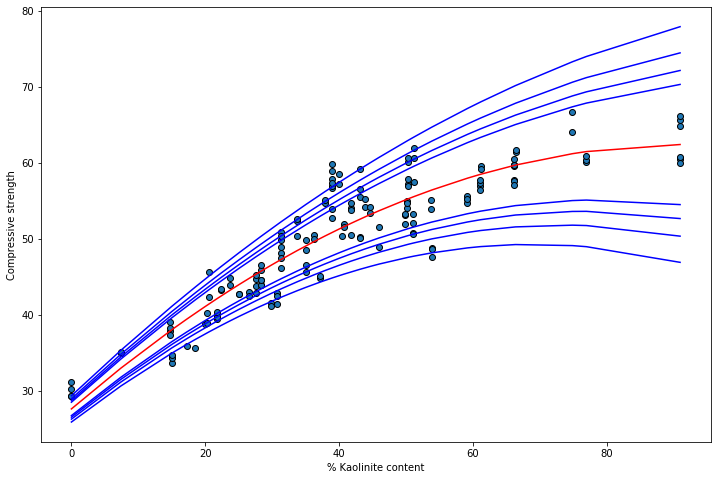

MSE: 11.177755734084075
R^2: 0.8520455681681612



In [38]:
X = data_90[['Kaolinite_content','Kaolinite_content_square']].values
y = data_90['day_90']

# Train and show the model
model = LinearRegression()
model.fit(X, y) 

mod = smf.ols(formula='day_90 ~ Kaolinite_content + Kaolinite_content_square', data=data_90)
np.random.seed(2)
res = mod.fit()

conf90 = res.conf_int(alpha=0.1)
conf80 = res.conf_int(alpha=0.2)
conf70 = res.conf_int(alpha=0.3)
conf60 = res.conf_int(alpha=0.4)

# This could be generalized but degree n >= 3 leads to overfitting!
print('f(x) = {0} + {1}*x + {2}*x^2'.format(res.params[0],res.params[1],res.params[2]))
    
# Get the list of predictions obtained while validating
predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(X[:,0], y, edgecolors=(0, 0, 0))

ax.plot(X[:,0], np.dot(X,[conf60[0][1],conf60[0][2]]) + conf60[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf70[0][1],conf70[0][2]]) + conf70[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf80[0][1],conf80[0][2]]) + conf80[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf90[0][1],conf90[0][2]]) + conf90[0][0],'b-')
ax.plot(X[:,0], np.dot(X,model.coef_) + model.intercept_,'r-')
ax.plot(X[:,0], np.dot(X,[conf90[1][1],conf90[1][2]]) + conf90[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf80[1][1],conf80[1][2]]) + conf80[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf70[1][1],conf70[1][2]]) + conf70[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf60[1][1],conf60[1][2]]) + conf60[1][0],'b-')

ax.set_xlabel('% Kaolinite content')
ax.set_ylabel('Compressive strength')
plt.show()

# Metrics for the model
print("MSE: {}".format(mean_squared_error(y, predicted)))
print("R^2: {}".format(model.score(X,y)))
print()

In [41]:
prstd, iv_l, iv_u = wls_prediction_std(res)

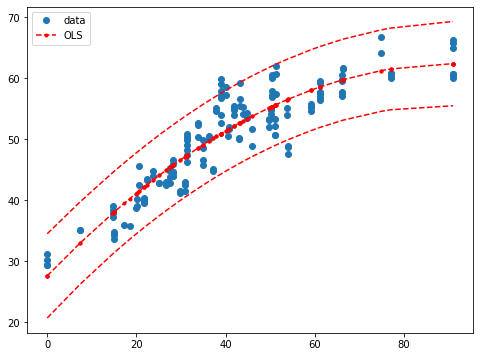

In [43]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x90, y90, 'o', label="data")
#ax.plot(x90, model.predict(x90.reshape(-1,1)), 'b-', label="True")
ax.plot(x90, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x90, iv_u, 'r--')
ax.plot(x90, iv_l, 'r--')
ax.legend(loc='best')

In [44]:
data_28=data_full_clay[['day_28','Kaolinite_content']].dropna().copy()
data_28.insert(2, 'Kaolinite_content_square', data_28['Kaolinite_content']**2, True)

f(x) = 27.502120699429785 + 0.6708050880810232*x + -0.0033879531411115304*x^2


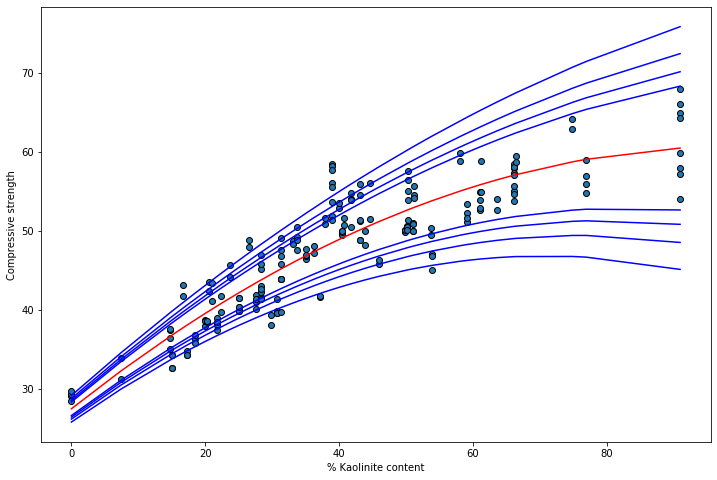

MSE: 12.368760880897868
R^2: 0.8195507057666824



In [45]:
X = data_28[['Kaolinite_content','Kaolinite_content_square']].values
y = data_28['day_28']

# Train and show the model
model = LinearRegression()
model.fit(X, y) 

mod = smf.ols(formula='day_28 ~ Kaolinite_content + Kaolinite_content_square', data=data_28)
np.random.seed(2)
res = mod.fit()

conf90 = res.conf_int(alpha=0.1)
conf80 = res.conf_int(alpha=0.2)
conf70 = res.conf_int(alpha=0.3)
conf60 = res.conf_int(alpha=0.4)

# This could be generalized but degree n >= 3 leads to overfitting!
print('f(x) = {0} + {1}*x + {2}*x^2'.format(res.params[0],res.params[1],res.params[2]))
    
# Get the list of predictions obtained while validating
predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(X[:,0], y, edgecolors=(0, 0, 0))

ax.plot(X[:,0], np.dot(X,[conf60[0][1],conf60[0][2]]) + conf60[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf70[0][1],conf70[0][2]]) + conf70[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf80[0][1],conf80[0][2]]) + conf80[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf90[0][1],conf90[0][2]]) + conf90[0][0],'b-')
ax.plot(X[:,0], np.dot(X,model.coef_) + model.intercept_,'r-')
ax.plot(X[:,0], np.dot(X,[conf90[1][1],conf90[1][2]]) + conf90[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf80[1][1],conf80[1][2]]) + conf80[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf70[1][1],conf70[1][2]]) + conf70[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf60[1][1],conf60[1][2]]) + conf60[1][0],'b-')

ax.set_xlabel('% Kaolinite content')
ax.set_ylabel('Compressive strength')
plt.show()

# Metrics for the model
print("MSE: {}".format(mean_squared_error(y, predicted)))
print("R^2: {}".format(model.score(X,y)))
print()

In [50]:
prstd, iv_l, iv_u = wls_prediction_std(res)

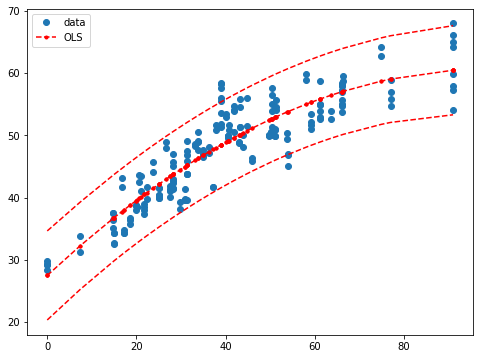

In [51]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x28, y28, 'o', label="data")
#ax.plot(x90, model.predict(x90.reshape(-1,1)), 'b-', label="True")
ax.plot(x28, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x28, iv_u, 'r--')
ax.plot(x28, iv_l, 'r--')
ax.legend(loc='best')

**First sight analysis:**

* We can't afford confidence intervals of such a high precission with such a lack of points, specially for high kaolinite contents.
* However, this worths a try after adding all the points from the second excel!

In [33]:
df_aux = data_full_clay[data_full_clay.Kaolinite_content<45]
df_aux = df_aux[df_aux.Kaolinite_content>40]
df_aux

,Clay,day_1,day_3,day_7,day_28,day_90,Origin of clay,Calcination,Kaolinite_content,Dv50,...,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
185,Guinea 2,9.96250,23.55000,39.75625,49.862183,NaN,NaN,NaN,40.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,Guinea 2,10.00000,23.73750,40.21250,49.993764,NaN,NaN,NaN,40.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,Guinea 2,9.67500,23.40000,39.29375,49.543619,50.441401,NaN,NaN,40.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,Guinea 2,9.96250,23.55000,39.75625,49.862183,NaN,NaN,NaN,40.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,Guinea 2,10.00000,23.73750,40.21250,49.993764,NaN,NaN,NaN,40.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,Titan 2,9.04375,23.00000,37.61875,50.812500,51.956250,Europe,Furnace,40.70,5.3,...,5.87374,0.3336,0.274028,0.238286,0.202543,0.000000,0,0,0.0714857,1.600000
131,Titan 2,10.51250,22.10000,37.63750,51.618750,51.593750,Europe,Furnace,40.70,5.3,...,5.87374,0.3336,0.274028,0.238286,0.202543,0.000000,0,0,0.0714857,1.600000
35,Portugal,9.71250,21.98125,37.57500,54.081250,55.368750,Europe,Furnace,41.83,9.1,...,0.224,0.374,-,0.219,3.513,0.399000,0.06,-,-,2.560000
34,Portugal,9.48750,22.91250,38.93750,50.531250,54.750000,Europe,Furnace,41.83,9.1,...,0.224,0.374,-,0.219,3.513,0.399000,0.06,-,-,2.560000
33,Portugal,9.76250,21.38125,36.30000,53.856250,53.900000,Europe,Furnace,41.83,9.1,...,0.224,0.374,-,0.219,3.513,0.399000,0.06,-,-,2.560000


### References:

* How to deal with small datasets:\
https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89

* Feature engineering: \
https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

* Feature selection: \
https://en.wikipedia.org/wiki/Feature_selection \
https://machinelearningmastery.com/an-introduction-to-feature-selection/ \
https://machinelearningmastery.com/feature-selection-machine-learning-python/ \
https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/ \
https://machinelearningmastery.com/calculate-feature-importance-with-python/

* Linear regression with python: \
https://realpython.com/linear-regression-in-python/ 

* Confidence estimation: \
https://www.puneetarora2000.com/2020/01/data-interpretation-understanding-ols.html \
https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01 \
https://www.statsmodels.org/stable/regression.html \

